In [1]:
import pandas as pd
import pdb
from google.colab import files

#Upload the file
uploaded = files.upload()

#Read the file
online_retail = list(uploaded.keys())[0]
df1 = pd.read_excel(online_retail, sheet_name="Year 2009-2010")
df2 = pd.read_excel(online_retail, sheet_name="Year 2010-2011")

#Concat the file
df = pd.concat([df1, df2])


Saving online_retail_II.xlsx to online_retail_II.xlsx


In [2]:
#Exploration Data Analysis

#Shape - tuple returns the rows and columns
print(f"(Rows, Columns) : {df.shape}")

#Print the dataset info
print(df.info())

#Checking for missing values
print(df.isnull().sum())

#Check for negative values(Returned items)
print(df[df['Quantity'] < 0].head())
print(f"Number of returns: {df[df['Quantity'] < 0].shape[0]}")

#Invoiced date parsed as Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#Drop customerID missing values
df = df.dropna(subset=['Customer ID'])
df['Customer ID'] = df['Customer ID'].astype(int)

#Not dropping the negative values for the following reasons
# 1. Understanding real customer value
# 2. Predicting customer churn or satisfaction
# 3. Customer segmentation or marketing


print(df.describe())


(Rows, Columns) : (1067371, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB
None
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64
     Invoice StockCode                    Description  Quantity  \
178  C4894

<ipython-input-2-951b6431a461>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer ID'] = df['Customer ID'].astype(int)


In [3]:
import datetime
#Top Customers
#print(df['CustomerId'].value_counts().head(10))
print(df['Customer ID'].value_counts().head(10))

#Top Countries
print(df['Country'].value_counts().head(5))

# Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Define snapshot date (next day after the most recent InvoiceDate)
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

Customer ID
17841    13097
14911    11613
12748     7307
14606     6709
14096     5128
15311     4717
14156     4130
14646     3890
13089     3438
16549     3255
Name: count, dtype: int64
Country
United Kingdom    741301
Germany            17624
EIRE               16195
France             14202
Netherlands         5140
Name: count, dtype: int64


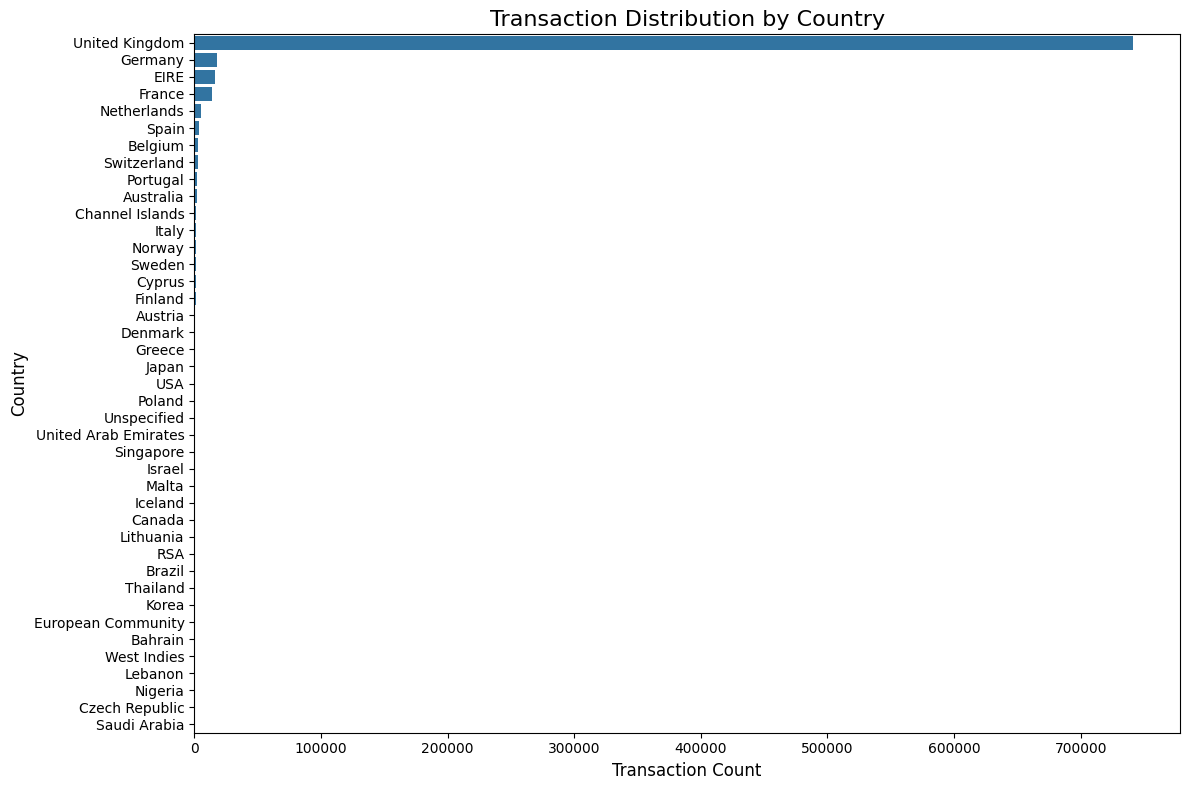

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate transaction count per country and sort
country_counts = df['Country'].value_counts().sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.barplot(x=country_counts.values, y=country_counts.index, orient='horizontal')

# Customize the plot
plt.title('Transaction Distribution by Country', fontsize=16)
plt.xlabel('Transaction Count', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()

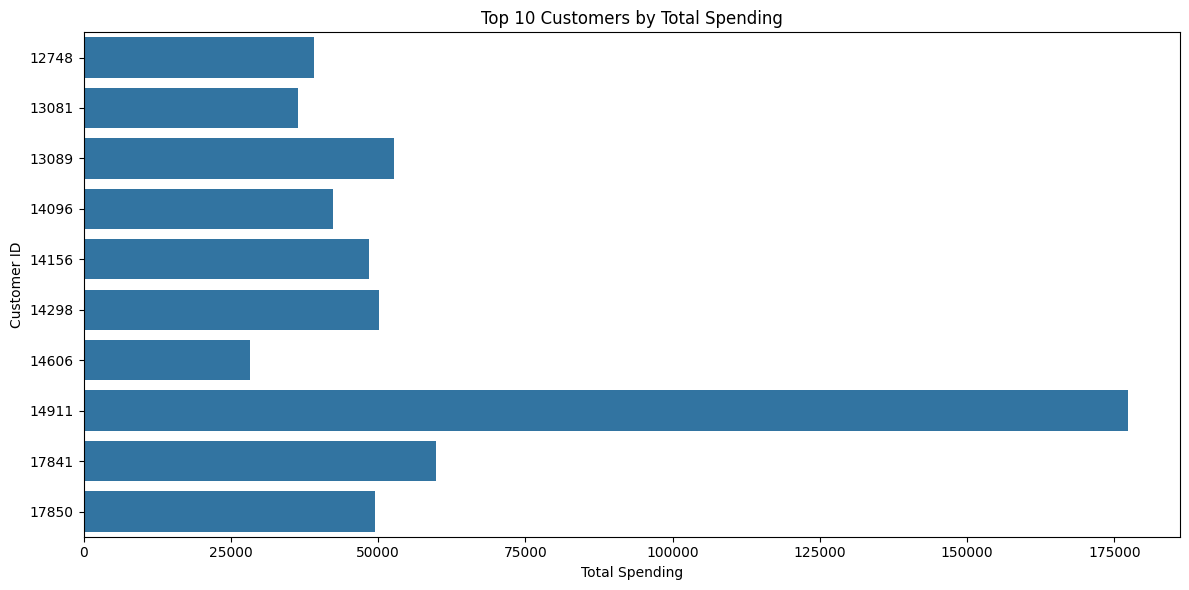

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#Remove Outlier(Interquartile range)
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]

#Calculate total spending per customer
customer_spending = df_clean.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False)

#Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_spending.head(10).values, y=customer_spending.head(10).index, orient='horizontal')  # Show top 10
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Total Spending')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


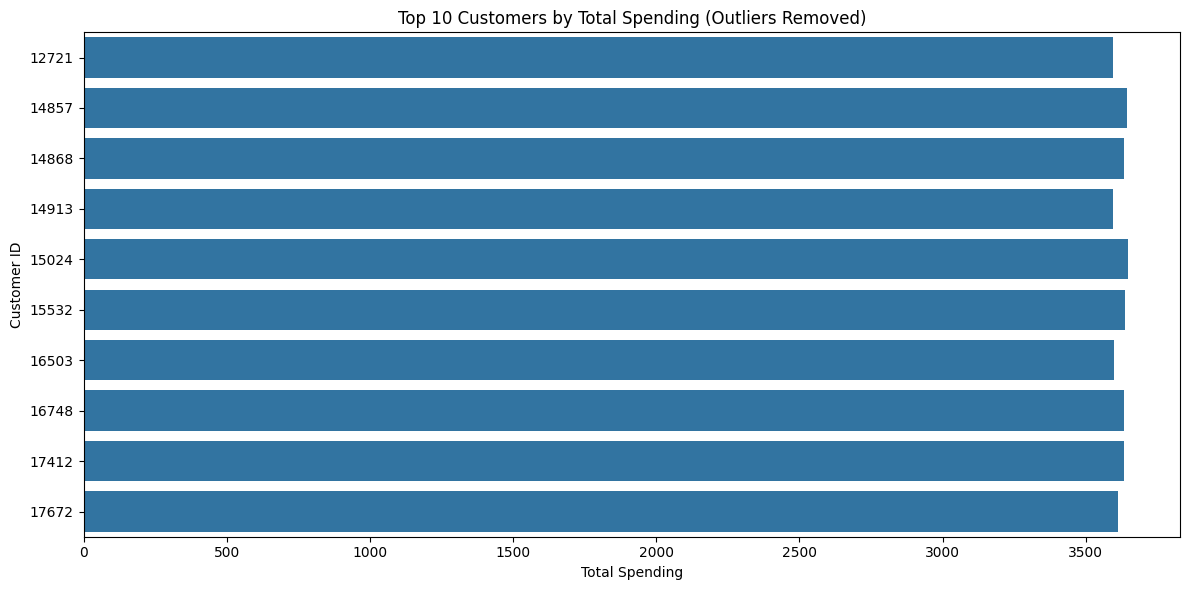

In [6]:
#Apply IQR After Aggregating by Customer
# Step 1: Aggregate total spending per customer
customer_spending = df_clean.groupby('Customer ID')['TotalPrice'].sum()

# Step 2: Apply IQR to the aggregated totals
Q1 = customer_spending.quantile(0.25)
Q3 = customer_spending.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out customers with extreme total spend
customer_spending_clean = customer_spending[(customer_spending >= lower_bound) & (customer_spending <= upper_bound)]

# Step 4: Plot top 10
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_spending_clean.sort_values(ascending=False).head(10).values,
            y=customer_spending_clean.sort_values(ascending=False).head(10).index,
            orient='horizontal')
plt.title('Top 10 Customers by Total Spending (Outliers Removed)')
plt.xlabel('Total Spending')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


In [7]:
#checking for nulls after removing outliers
customer_spending_clean.isnull().sum()
df_clean.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0
TotalPrice,0


In [16]:
#Feature Engineering
import datetime
from IPython.display import display

# RFM Aggregation
rfm = df_clean.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

# Calculate AvgSpendPerPurchase
rfm['AvgSpendPerPurchase'] = rfm['Monetary'] / rfm['Frequency']

# Identify high spenders based on 80th percentile of Monetary value
threshold = rfm['Monetary'].quantile(0.80)
rfm['IsHighSpender'] = (rfm['Monetary'] >= threshold).astype(int)

# Determine top 5 countries and label others as 'Other'
top_countries = df_clean['Country'].value_counts().head(5).index
df_clean['TopCountry'] = df_clean['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Merge TopCountry info into RFM
rfm = rfm.merge(df_clean[['Customer ID', 'TopCountry']].drop_duplicates(), on='Customer ID', how='left')

# Calculate Weekend Purchase Rate (Proportion of weekend purchases)
df_clean['IsWeekend'] = df_clean['InvoiceDate'].dt.weekday >= 5
weekend_ratio = df_clean.groupby('Customer ID')['IsWeekend'].mean().reset_index(name='WeekendPurchaseRate')

# Merge WeekendPurchaseRate into RFM
rfm = rfm.merge(weekend_ratio, on='Customer ID', how='left')

# Calculate Return Rate (Proportion of returned purchases)
returns = df_clean[df_clean['Quantity'] < 0].groupby('Customer ID')['Invoice'].count()
purchases = df_clean[df_clean['Quantity'] > 0].groupby('Customer ID')['Invoice'].count()
return_rate = (returns / purchases).fillna(0).reset_index(name='ReturnRate')

# Merge ReturnRate into RFM
rfm = rfm.merge(return_rate, on='Customer ID', how='left')

# Final RFM dataframe
#rfm.head()  # Display the resulting dataframe

rfm.info()

#display(rfm)


<ipython-input-16-f374ffeafa86>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TopCountry'] = df_clean['Country'].apply(lambda x: x if x in top_countries else 'Other')
<ipython-input-16-f374ffeafa86>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['IsWeekend'] = df_clean['InvoiceDate'].dt.weekday >= 5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer ID          5725 non-null   int64  
 1   Recency              5725 non-null   int64  
 2   Frequency            5725 non-null   int64  
 3   Monetary             5725 non-null   float64
 4   AvgSpendPerPurchase  5725 non-null   float64
 5   IsHighSpender        5725 non-null   int64  
 6   TopCountry           5725 non-null   object 
 7   WeekendPurchaseRate  5725 non-null   float64
 8   ReturnRate           5725 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 402.7+ KB


In [9]:
# Drop the columns
rfm = rfm.drop(columns=['TopCountry', 'AvgSpendPerPurchase'])
rfm.head()

,Customer ID,Recency,Frequency,Monetary,IsHighSpender,WeekendPurchaseRate,ReturnRate
0,12346,431,13,285.49,0,0.000000,0.218750
1,12347,2,8,4371.34,1,0.168776,0.000000
2,12348,75,5,823.80,0,0.025641,0.000000
3,12349,19,4,2819.84,1,0.000000,0.031447
4,12350,310,1,334.40,0,0.000000,0.000000


In [10]:
#Normalize the RFM Features
from sklearn.preprocessing import StandardScaler

features_to_scale = ['Recency', 'Frequency', 'Monetary', 'WeekendPurchaseRate', 'ReturnRate']

#Standard Scaler
standard_scaler = StandardScaler()
rfm_standard_scaled = standard_scaler.fit_transform(rfm[features_to_scale])


In [11]:
#Apply Principal component Analysis
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Apply PCA to reduce the dataset to 2 components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(rfm_standard_scaled)

# Variance explained by each principal component
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", np.sum(pca.explained_variance_ratio_))


Explained Variance Ratio: [0.39302084 0.21309313 0.18738906 0.17496266]
Total Variance Explained: 0.9684656897010425


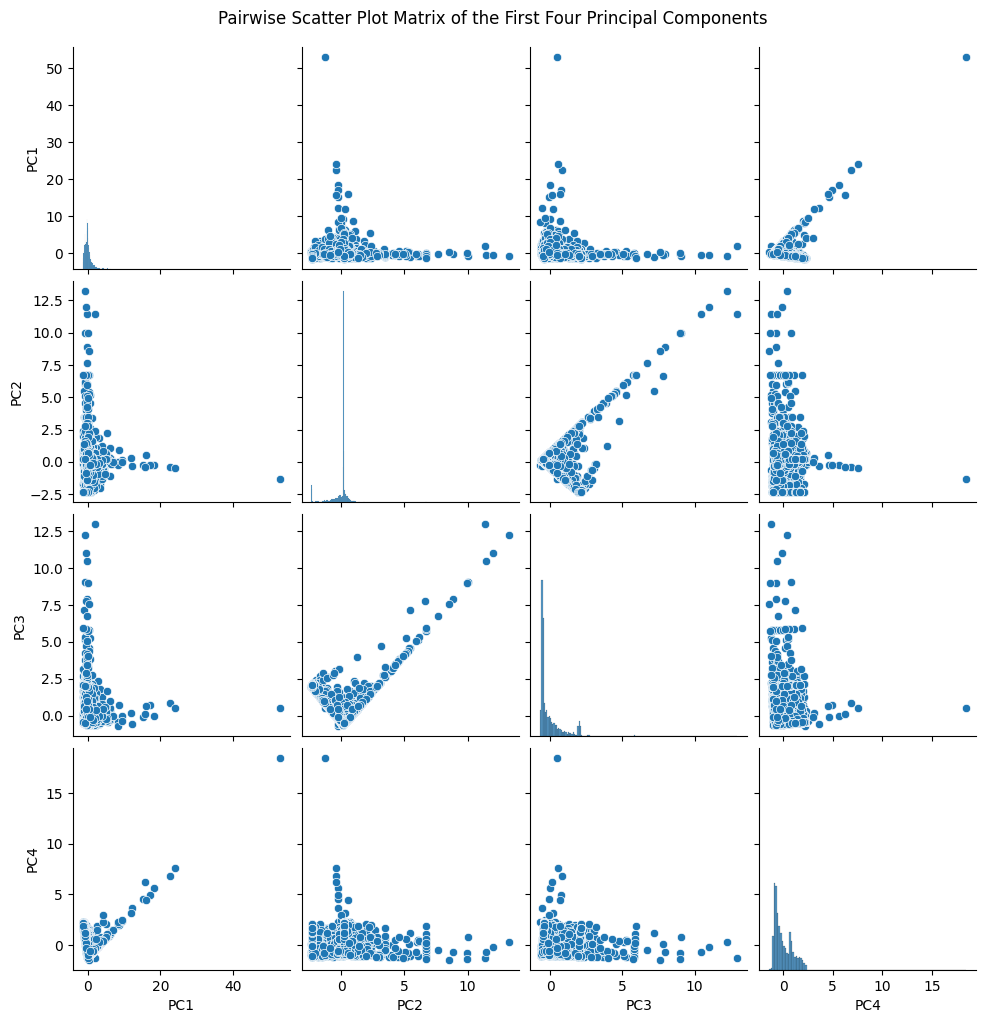

In [12]:
import seaborn as sns
import pandas as pd

# Convert PCA components to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Create a pairplot (scatter matrix)
sns.pairplot(pca_df)
plt.suptitle("Pairwise Scatter Plot Matrix of the First Four Principal Components", y=1.02)
plt.show()

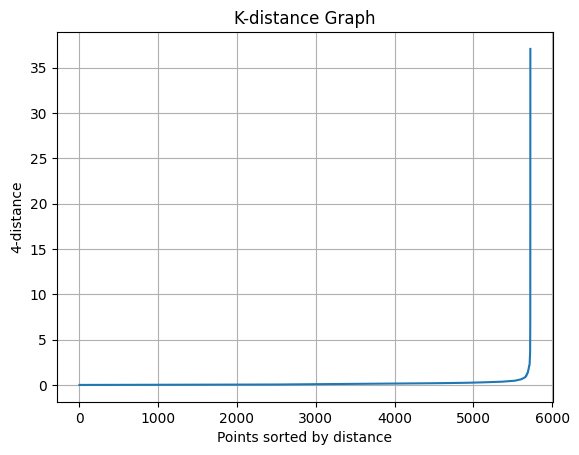

In [18]:
#Find Neighbourhood radius(Kdistance plot) and Minimum number of points(min_samples)
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Choose your value of k (usually same as min_samples)
k = 4  # Common rule of thumb: min_samples = number of dimensions + 1

# Fit NearestNeighbors on your PCA-transformed data
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_pca)  # assuming X_pca is your PCA-transformed data

# Find the k-distance for each point
distances, indices = nbrs.kneighbors(X_pca)

# Sort the distances for plotting
distances = np.sort(distances[:, k-1])  # k-th NN distance for each point
plt.plot(distances)
plt.ylabel(f'{k}-distance')
plt.xlabel('Points sorted by distance')
plt.title('K-distance Graph')
plt.grid(True)
plt.show()

In [20]:
#Evaluate the Silhouette score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.5, 0.6, 0.7, 0.8, 0.9]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=8)
    labels = db.fit_predict(X_pca)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X_pca, labels)
        print(f"eps: {eps}, clusters: {n_clusters}, silhouette: {score:.2f}")
    else:
        print(f"eps: {eps}, too few clusters")

eps: 0.5, clusters: 2, silhouette: 0.62
eps: 0.6, clusters: 2, silhouette: 0.50
eps: 0.7, clusters: 2, silhouette: 0.71
eps: 0.8, clusters: 2, silhouette: 0.75
eps: 0.9, clusters: 2, silhouette: 0.75


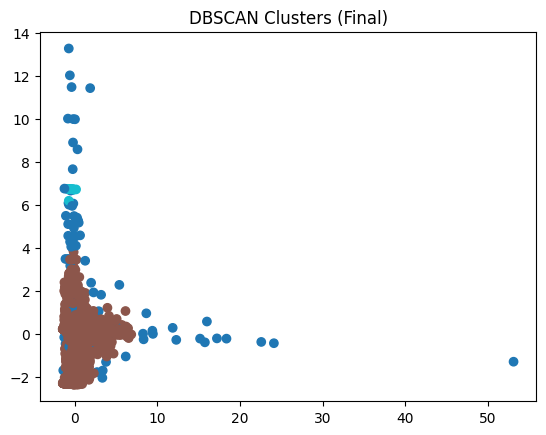

In [21]:
#DBSCAN (Density-Based Spatial Clustering)
dbscan = DBSCAN(eps=0.8, min_samples=8)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=rfm['DBSCAN_Cluster'], cmap='tab10')
plt.title('DBSCAN Clusters (Final)')
plt.show()

In [22]:
#Analyzing the cluster profiles
rfm['Cluster'] = rfm['DBSCAN_Cluster']

cluster_profiles = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print(cluster_profiles)

         Recency  Frequency  Monetary
Cluster                              
-1        213.06      44.59  10303.18
 0        200.45       6.36   1407.67
 1        234.85       2.77     27.17


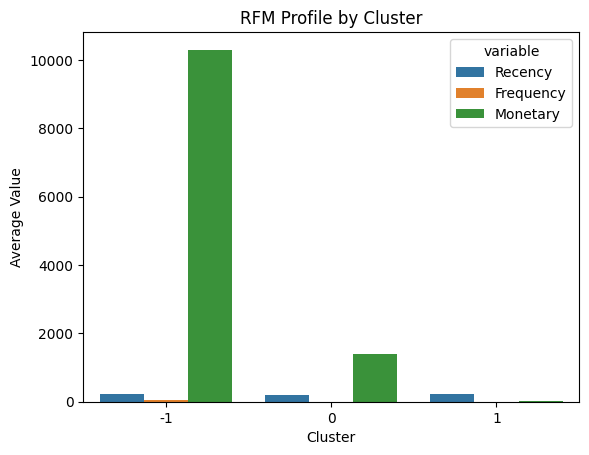

In [23]:
import seaborn as sns

cluster_profiles.reset_index(inplace=True)
cluster_profiles_melted = cluster_profiles.melt(id_vars='Cluster')
sns.barplot(data=cluster_profiles_melted, x='Cluster', y='value', hue='variable')
plt.title("RFM Profile by Cluster")
plt.ylabel("Average Value")
plt.show()

In [24]:
# Business-friendly labels mapped directly
cluster_labels = {
    0: 'Loyal High-Spenders',
    1: 'At-Risk Customers',
    2: 'Recent Shoppers',
    -1: 'Noise/Outliers'
}

# Assign labels to the Segment column
rfm['Segment'] = rfm['Cluster'].map(cluster_labels).fillna('Other')

In [25]:

rfm['Segment'].value_counts()



,count
Segment,
Loyal High-Spenders,5629
Noise/Outliers,83
At-Risk Customers,13
